<a href="https://colab.research.google.com/github/SergeyShchus/Automatic_GIS/blob/master/Notebook/Geopandas/Nearest_neighbor_analysis_with_large_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
# Install OpticalRS. This also installs GeoPandas because GeoPandas is a dependency of OpticalRS
!apt-get install software-properties-common python-software-properties > /dev/null
!add-apt-repository ppa:ubuntugis/ppa -y > /dev/null
!apt-get update > /dev/null
!apt-get install -y --fix-missing python-gdal gdal-bin libgdal-dev > /dev/null
!pip2 install OpticalRS > /dev/null

! pip install geopandas

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
from zipfile import ZipFile
import io

def read_gdf_from_zip(zip_fp):
    """
    Reads a spatial dataset from ZipFile into GeoPandas. Assumes that there is only a single file (such as GeoPackage) 
    inside the ZipFile.
    """
    with ZipFile(zip_fp) as z:
        # Lists all files inside the ZipFile, here assumes that there is only a single file inside
        layer = z.namelist()[0]
        data = gpd.read_file(io.BytesIO(z.read(layer)))
    return data

# Filepaths
stops = gpd.read_file('/content/pt_stops_helsinki.gpkg')
buildings = read_gdf_from_zip('/content/building_points_helsinki.zip')

/usr/local/lib/python3.7/dist-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [3]:
print(buildings.head(), '\n--------')
print(stops.head())

             name                   geometry
0            None  POINT (24.85584 60.20727)
1     Uimastadion  POINT (24.93045 60.18882)
2            None  POINT (24.95113 60.16994)
3  Hartwall Arena  POINT (24.92918 60.20570)
4           Talli  POINT (24.92607 60.21346) 
--------
     stop_name   stop_lat   stop_lon  stop_id                   geometry
0  Ritarihuone  60.169460  24.956670  1010102  POINT (24.95667 60.16946)
1   Kirkkokatu  60.171270  24.956570  1010103  POINT (24.95657 60.17127)
2   Kirkkokatu  60.170293  24.956721  1010104  POINT (24.95672 60.17029)
3    Vironkatu  60.172580  24.956554  1010105  POINT (24.95655 60.17258)
4    Vironkatu  60.172990  24.956380  1010106  POINT (24.95638 60.17299)


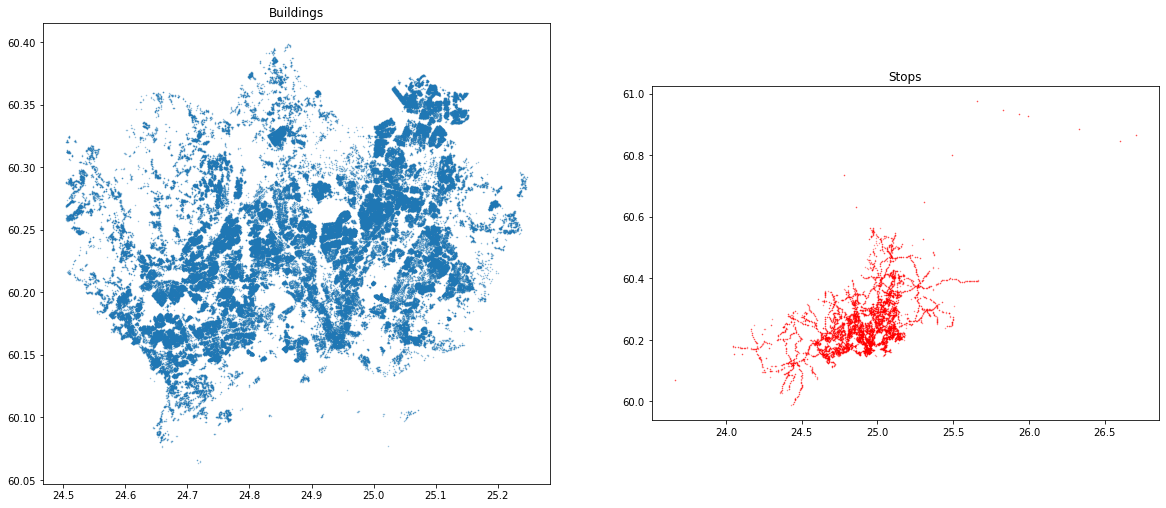

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes=plt.subplots(nrows=1, ncols=2, figsize=(20,10))

# Plot buildings
buildings.plot(ax=axes[0],markersize=0.2, alpha=0.5)
axes[0].set_title('Buildings')

# Plot stops
stops.plot(ax=axes[1], markersize=0.2, alpha=0.5, color='red')
axes[1].set_title('Stops');

In [8]:
from sklearn.neighbors import BallTree
import numpy as np

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""

    # Create tree from the candidate points
    tree = BallTree(candidates, leaf_size=15, metric='haversine')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    # note: for the second closest points, you would take index 1, etc.
    closest = indices[0]
    closest_dist = distances[0]

    # Return indices and distances
    return (closest, closest_dist)


def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    NOTICE: Assumes that the input Points are in WGS84 projection (lat/lon).
    """
    
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    
    # Ensure that index in right gdf is formed of sequential numbers
    right = right_gdf.copy().reset_index(drop=True)
    
    # Parse coordinates from points and insert them into a numpy array as RADIANS
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: (geom.x * np.pi / 180, geom.y * np.pi / 180)).to_list())
    
    # Find the nearest points
    # -----------------------
    # closest ==> index in right_gdf that corresponds to the closest point
    # dist ==> distance between the nearest neighbors (in meters)
    
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)

    # Return points from right GeoDataFrame that are closest to points in left GeoDataFrame
    closest_points = right.loc[closest]
    
    # Ensure that the index corresponds the one in left_gdf
    closest_points = closest_points.reset_index(drop=True)
    
    # Add distance if requested 
    if return_dist:
        # Convert to meters from radians
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
        
    return closest_points

In [9]:
# Find closest public transport stop for each building and get also the distance based on haversine distance 
# Note: haversine distance which is implemented here is a bit slower than using e.g. 'euclidean' metric 
# but useful as we get the distance between points in meters
closest_stops = nearest_neighbor(buildings, stops, return_dist=True)

# And the result looks like ..
closest_stops

,stop_name,stop_lat,stop_lon,stop_id,geometry,distance
0,Muusantori,60.207490,24.857450,1304138,POINT (24.85745 60.20749),180.521584
1,Eläintarha,60.192490,24.930840,1171120,POINT (24.93084 60.19249),372.665221
2,Senaatintori,60.169010,24.950460,1020450,POINT (24.95046 60.16901),119.425777
3,Veturitie,60.206610,24.929680,1174112,POINT (24.92968 60.20661),106.762619
4,Autokuljetuskeskus 1,60.218810,24.923110,1286161,POINT (24.92311 60.21881),631.794206
...,...,...,...,...,...,...
158726,Bredantie,60.212770,24.723210,3170222,POINT (24.72321 60.21277),200.454057
158727,Kasavuori,60.211112,24.699637,3170256,POINT (24.69964 60.21111),262.973726
158728,Kandidaatintie,60.218180,24.736987,3170245,POINT (24.73699 60.21818),175.043184
158729,Uimahalli,60.215660,24.712090,3170213,POINT (24.71209 60.21566),139.212653


In [10]:
# Now we should have exactly the same number of closest_stops as we have buildings
print(len(closest_stops), '==', len(buildings))

158731 == 158731


https://jakevdp.github.io/blog/2013/04/29/benchmarking-nearest-neighbor-searches-in-python/

In [11]:
# Rename the geometry of closest stops gdf so that we can easily identify it
closest_stops = closest_stops.rename(columns={'geometry': 'closest_stop_geom'})

# Merge the datasets by index (for this, it is good to use '.join()' -function)
buildings = buildings.join(closest_stops)

# Let's see what we have
buildings.head()

,name,geometry,stop_name,stop_lat,stop_lon,stop_id,closest_stop_geom,distance
0,None,POINT (24.85584 60.20727),Muusantori,60.20749,24.85745,1304138,POINT (24.85745 60.20749),180.521584
1,Uimastadion,POINT (24.93045 60.18882),Eläintarha,60.19249,24.93084,1171120,POINT (24.93084 60.19249),372.665221
2,None,POINT (24.95113 60.16994),Senaatintori,60.16901,24.95046,1020450,POINT (24.95046 60.16901),119.425777
3,Hartwall Arena,POINT (24.92918 60.20570),Veturitie,60.20661,24.92968,1174112,POINT (24.92968 60.20661),106.762619
4,Talli,POINT (24.92607 60.21346),Autokuljetuskeskus 1,60.21881,24.92311,1286161,POINT (24.92311 60.21881),631.794206


In [16]:
buildings['distance'].describe()

count    158731.000000
mean        299.288617
std         372.787458
min           1.358302
25%         133.853322
50%         218.742047
75%         341.648944
max        7153.941499
Name: distance, dtype: float64

In [17]:
!pip install mapclassify

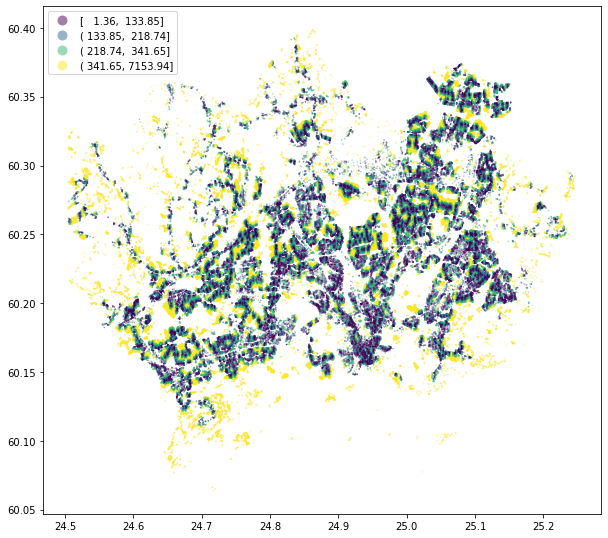

In [18]:
buildings.plot(column='distance', markersize=0.2, alpha=0.5, figsize=(10,10), scheme='quantiles', k=4, 
               legend=True)

In [19]:
from shapely.geometry import LineString

# Create a link (LineString) between building and stop points
buildings['link'] = buildings.apply(lambda row: LineString([row['geometry'], row['closest_stop_geom']]), axis=1)

# Set link as the active geometry
building_links = buildings.copy()
building_links = building_links.set_geometry('link')

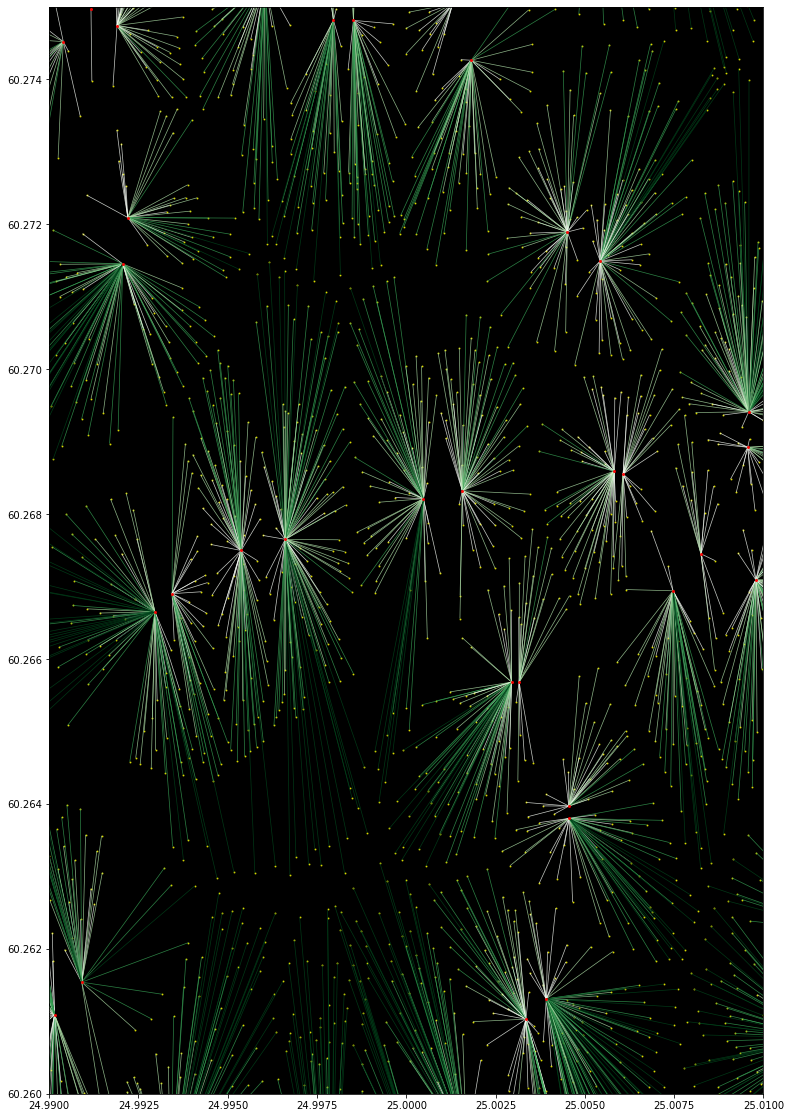

In [21]:
# Plot the connecting links between buildings and stops and color them based on distance
ax = building_links.plot(column='distance', cmap='Greens', scheme='quantiles', k=4, alpha=0.8, lw=0.7, figsize=(13, 20))
ax = buildings.plot(ax=ax, color='yellow', markersize=1, alpha=0.7)
ax = stops.plot(ax=ax, markersize=4, marker='o', color='red', alpha=0.9, zorder=3)

# Zoom closer
ax.set_xlim([24.99, 25.01])
ax.set_ylim([60.26, 60.275])

# Set map background color to black, which helps with contrast
ax.set_facecolor('black')